# Дано

`Классификация текстовых отзывов на положительные и отрицательные с использованием Опорно-векторных Машин (SVM) и ядер`<br><br>

**data**<br>
`marketplace` - 2-буквенный код страны рынка, где был написан обзор<br>
`customer_id` - Случайный идентификатор, который можно использовать для объединения обзоров, написанных одним автором<br>
`review_id` - Уникальный идентификатор обзора<br>
`product_id` - Уникальный идентификатор продукта, к которому относится обзор. В многоязычном наборе данных обзоры одного и того же продукта в разных странах могут быть сгруппированы по одному и тому же product_id<br>
`product_parent` - Случайный идентификатор, который можно использовать для объединения отзывов об одном и том же продукте<br>
`product_title` - Название продукта<br>
`product_category` - Широкая категория продуктов, которую можно использовать для группировки обзоров (также используется для группировки набора данных в связные части)<br>
`star_rating` - Рейтинг отзыва от 1 до 5 звезд<br>
`helpful_votes` - Количество полезных голосов<br>
`total_votes` - Общее количество голосов, полученных обзором<br>
`vine` - Обзор был написан в рамках программы Vine<br>
`verified_purchase` - Отзыв относится к проверенной покупке<br>
`review_headline` - Название обзора<br>
`review_body` - Текст обзора<br>
`review_date` - Дата написания обзора<br><br>

https://www.kaggle.com/datasets/cynthiarempel/amazon-us-customer-reviews-dataset

---

# Импорт библиотек

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import string
import nltk
import string

from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from scipy.sparse import hstack

import warnings
warnings.filterwarnings('ignore')

---

# Загрузка данных

> есть битые строки из-за которых нельзя прочитать файл, мы их пропускаем с помощью `on_bad_lines` и сразу преобразуем признак с датой с помощью `parse_dates`

In [2]:
data = pd.read_csv('/kaggle/input/amazon-us-customer-reviews-dataset/amazon_reviews_us_Books_v1_02.tsv',
                   sep = '\t',
                   on_bad_lines = 'skip',
                   parse_dates = ['review_date'])

---

# Общая информация

In [3]:
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3105370 entries, 0 to 3105369
Data columns (total 15 columns):
 #   Column             Dtype         
---  ------             -----         
 0   marketplace        object        
 1   customer_id        int64         
 2   review_id          object        
 3   product_id         object        
 4   product_parent     int64         
 5   product_title      object        
 6   product_category   object        
 7   star_rating        float64       
 8   helpful_votes      float64       
 9   total_votes        float64       
 10  vine               object        
 11  verified_purchase  object        
 12  review_headline    object        
 13  review_body        object        
 14  review_date        datetime64[ns]
dtypes: datetime64[ns](1), float64(3), int64(2), object(9)
memory usage: 355.4+ MB


,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,12076615,RQ58W7SMO911M,0385730586,122662979,Sisterhood of the Traveling Pants (Book 1),Books,4.0,2.0,3.0,N,N,this book was a great learning novel!,this boook was a great one that you could lear...,2005-10-14
1,US,12703090,RF6IUKMGL8SF,0811828964,56191234,The Bad Girl's Guide to Getting What You Want,Books,3.0,5.0,5.0,N,N,Fun Fluff,If you are looking for something to stimulate ...,2005-10-14
2,US,12257412,R1DOSHH6AI622S,1844161560,253182049,"Eisenhorn (A Warhammer 40,000 Omnibus)",Books,4.0,1.0,22.0,N,N,this isn't a review,never read it-a young relative idicated he lik...,2005-10-14
3,US,50732546,RATOTLA3OF70O,0373836635,348672532,Colby Conspiracy (Colby Agency),Books,5.0,2.0,2.0,N,N,fine author on her A-game,Though she is honored to be Chicago Woman of t...,2005-10-14
4,US,51964897,R1TNWRKIVHVYOV,0262181533,598678717,The Psychology of Proof: Deductive Reasoning i...,Books,4.0,0.0,2.0,N,N,Execellent cursor examination,Review based on a cursory examination by Unive...,2005-10-14


> у нас имеется 3 105 369 отзывов, так же изменим у нескольких признаков типы данных<br>
> `star_rating` - int<br>
> `helpful_votes` - int<br>
> `total_votes` - int<br>
> но получится это сделать после проверки пропусков, так как если они есть, то nan на int мы поменять не сможем

---

# Дубликаты

> перед анализом и обработкой пропусков посмотрим на дубликаты, которые могут испортить последующий анализ

In [4]:
print(f'Количество дубликатов таблицы data: {data.duplicated().sum()}')

Количество дубликатов таблицы data: 0


----

# Пропуски

In [5]:
print(f'Количество пропусков таблицы data: {sum(data.isnull().sum())}')

Количество пропусков таблицы data: 214


In [6]:
print(f'Пропущенные значения таблицы data по признакам: \n{data.isnull().sum()}')

Пропущенные значения таблицы data по признакам: 
marketplace            0
customer_id            0
review_id              0
product_id             0
product_parent         0
product_title          0
product_category       0
star_rating            4
helpful_votes          4
total_votes            4
vine                   4
verified_purchase      4
review_headline       57
review_body            4
review_date          133
dtype: int64


> так как 214 пропущенных занчения невероятно маленькое количество в разрезе 3 миллионов экземпляров, то их проще удалить, нежели тратить силы на их обработку, ибо это просто не даст никакого прироста

In [7]:
data.dropna(inplace = True)

print(f'Количество пропусков таблицы data: {sum(data.isnull().sum())}')

Количество пропусков таблицы data: 0


> теперь можно изменить типы данных

In [8]:
data['star_rating'] = data['star_rating'].astype(int)
data['helpful_votes'] = data['helpful_votes'].astype(int)
data['total_votes'] = data['total_votes'].astype(int)

data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3105184 entries, 0 to 3105369
Data columns (total 15 columns):
 #   Column             Dtype         
---  ------             -----         
 0   marketplace        object        
 1   customer_id        int64         
 2   review_id          object        
 3   product_id         object        
 4   product_parent     int64         
 5   product_title      object        
 6   product_category   object        
 7   star_rating        int64         
 8   helpful_votes      int64         
 9   total_votes        int64         
 10  vine               object        
 11  verified_purchase  object        
 12  review_headline    object        
 13  review_body        object        
 14  review_date        datetime64[ns]
dtypes: datetime64[ns](1), int64(5), object(9)
memory usage: 379.1+ MB


---

# Избавляемся от бесполезных признаков

> псмотрим на кол-во уникальных элементов каждогопризнака

In [9]:
data.nunique()

marketplace                1
customer_id          1502265
review_id            3105184
product_id            779692
product_parent        666003
product_title         713665
product_category           1
star_rating                5
helpful_votes            942
total_votes             1024
vine                       2
verified_purchase          2
review_headline      2456998
review_body          3070458
review_date             3575
dtype: int64

> делаем вывод, что у нас есть бесполезные признаки - посмотрим на `marketplace`, `review_id` и `product_category`

In [10]:
print(f'\t marketplace: \n{data["marketplace"].value_counts()}\n')
print(f'\t review_id: \n{data["review_id"].value_counts()}\n')
print(f'\t product_category: \n{data["product_category"].value_counts()}\n')

	 marketplace: 
marketplace
US    3105184
Name: count, dtype: int64

	 review_id: 
review_id
RQ58W7SMO911M     1
RJWZ7O15U1S8A     1
R1UHYQTBRS3NSC    1
R2PYUR3NIJYZVY    1
R1LY9R8YIK5YGN    1
                 ..
R3VFDFM0AAWAJB    1
R4Q964NLUU1S3     1
R35ORSY6031QVK    1
R39H7PWR972S9I    1
R34N4QWDXX58WB    1
Name: count, Length: 3105184, dtype: int64

	 product_category: 
product_category
Books    3105184
Name: count, dtype: int64



> `marketplace` - страна везде us, неинформативен, можно удалять<br>
> `treview_id` - уникальный, бесполезен, можно удалять<br>
> `product_category` - везде категория книги, неинформативен, можно удалять

> `customer_id`, `product_id`, `product_paren`, `product_title` - соишком много уникальных значений, агрегация будет бессмысленна, можно избавиться

In [11]:
data.drop(['marketplace', 'review_id', 'product_category', 'customer_id', 'product_id', 'product_parent', 'product_title'], axis = 1, inplace = True)

data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3105184 entries, 0 to 3105369
Data columns (total 8 columns):
 #   Column             Dtype         
---  ------             -----         
 0   star_rating        int64         
 1   helpful_votes      int64         
 2   total_votes        int64         
 3   vine               object        
 4   verified_purchase  object        
 5   review_headline    object        
 6   review_body        object        
 7   review_date        datetime64[ns]
dtypes: datetime64[ns](1), int64(3), object(4)
memory usage: 213.2+ MB


---

# Анализ целевого признака - оценка отзывов

> посмтрим на распредление star_rating для понимани баланса классов

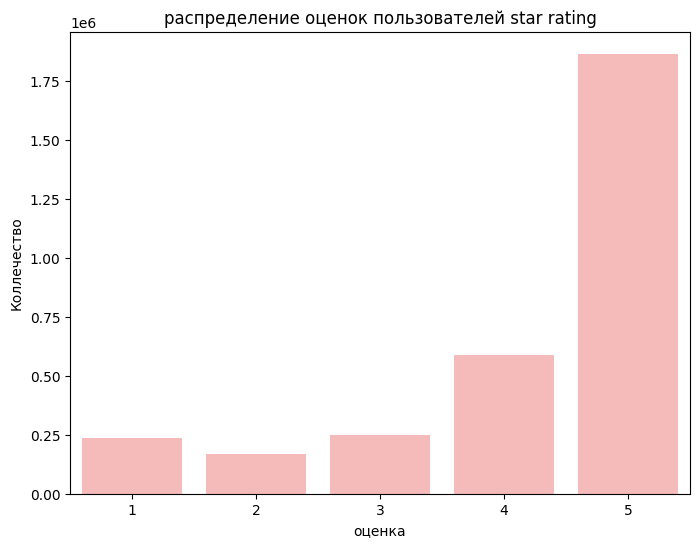

In [12]:
plt.figure(figsize = (8, 6))

sns.countplot(data = data, x = 'star_rating', color = 'red', alpha = 0.3)

plt.title('распределение оценок пользователей star rating')
plt.xlabel('оценка')
plt.ylabel('Коллечество')

plt.show()

> распредление сильно смещено к оценке 5 - очевидный и достаточно сильный дисбаланс. Так как бОльшая часть отзывов положительная - и чтобы svm не игнорировала классы с меньшим количеством записей, при обучении нужно будет задать `class_weight = 'balanced'`, потому что варианты с Upsampling или downsampling звучит как плохой вариант, так как дисбаланс, опять же, достаточно сильный.

> так как задача состоит в определении положительных и отрицательных классов, нужно сделать новый признак, который будет распределен следующим образом:br>
>- `1-2` - заменим на `0` - отрицательный отзыв
>- `3` - нейтральынй, просто удалим отзывы с оценкой 3
>- `4-5` - заменим на `1` - положительный отзыв

In [13]:
data = data[data['star_rating'] != 3]

data['label'] = data['star_rating'].apply(lambda x: 1 if x > 3 else 0)

> теперь избавимся от признака star_rating, так как даже сейчас очевидно, что он будет максимально коррелировать с целевой переменной label и испортит модель

In [14]:
data.drop(['star_rating'], axis = 1, inplace = True)

> а теперь посмотрим на распределение нашего нового целевого признака

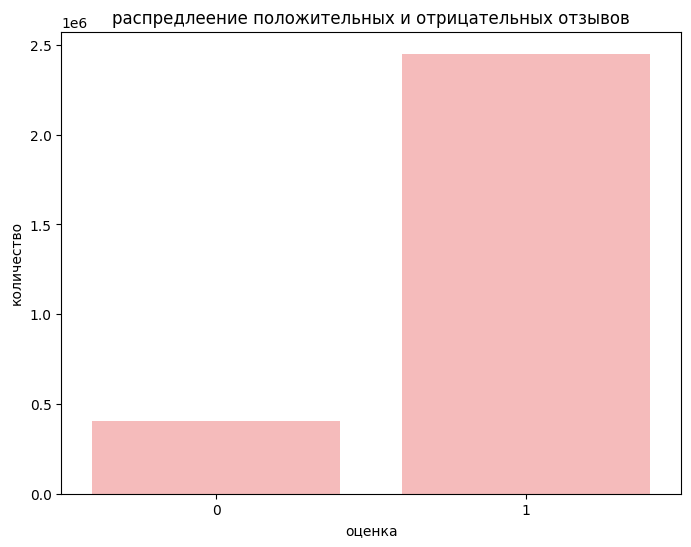

In [15]:
plt.figure(figsize = (8, 6))

sns.countplot(data = data, x = 'label', color = 'red', alpha = 0.3)

plt.title('распредлеение положительных и отрицательных отзывов')
plt.xlabel('оценка')
plt.ylabel('количество')

plt.show()

---

# Анализ признаков даты и полезности отзвов

> У нас есть принак с датой - вытащим год и месяц, посмотрим вдруг раньше отзываыв были отрицательные или наоборот

In [16]:
# год и месяц
data['review_date'] = pd.to_datetime(data['review_date'], errors='coerce')
data['review_year'] = data['review_date'].dt.year
data['review_month'] = data['review_date'].dt.month

# helpful_ratio - доля полезных голосов (+1, чтобы не было деления на 0 при ошибках в данных и если голосов нету, тоже получим полезность)
data['helpful_ratio'] = data['helpful_votes'] / (data['total_votes'] + 1)

data.head()

,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,label,review_year,review_month,helpful_ratio
0,2,3,N,N,this book was a great learning novel!,this boook was a great one that you could lear...,2005-10-14,1,2005,10,0.500000
2,1,22,N,N,this isn't a review,never read it-a young relative idicated he lik...,2005-10-14,1,2005,10,0.043478
3,2,2,N,N,fine author on her A-game,Though she is honored to be Chicago Woman of t...,2005-10-14,1,2005,10,0.666667
4,0,2,N,N,Execellent cursor examination,Review based on a cursory examination by Unive...,2005-10-14,1,2005,10,0.000000
5,2,2,N,N,"Interesting, fun.",My only complaint is that this book was a bit ...,2005-10-14,1,2005,10,0.666667


> посомтрим на разброс и информативность helpful_votes, total_votes, helpful_ratio и review_year

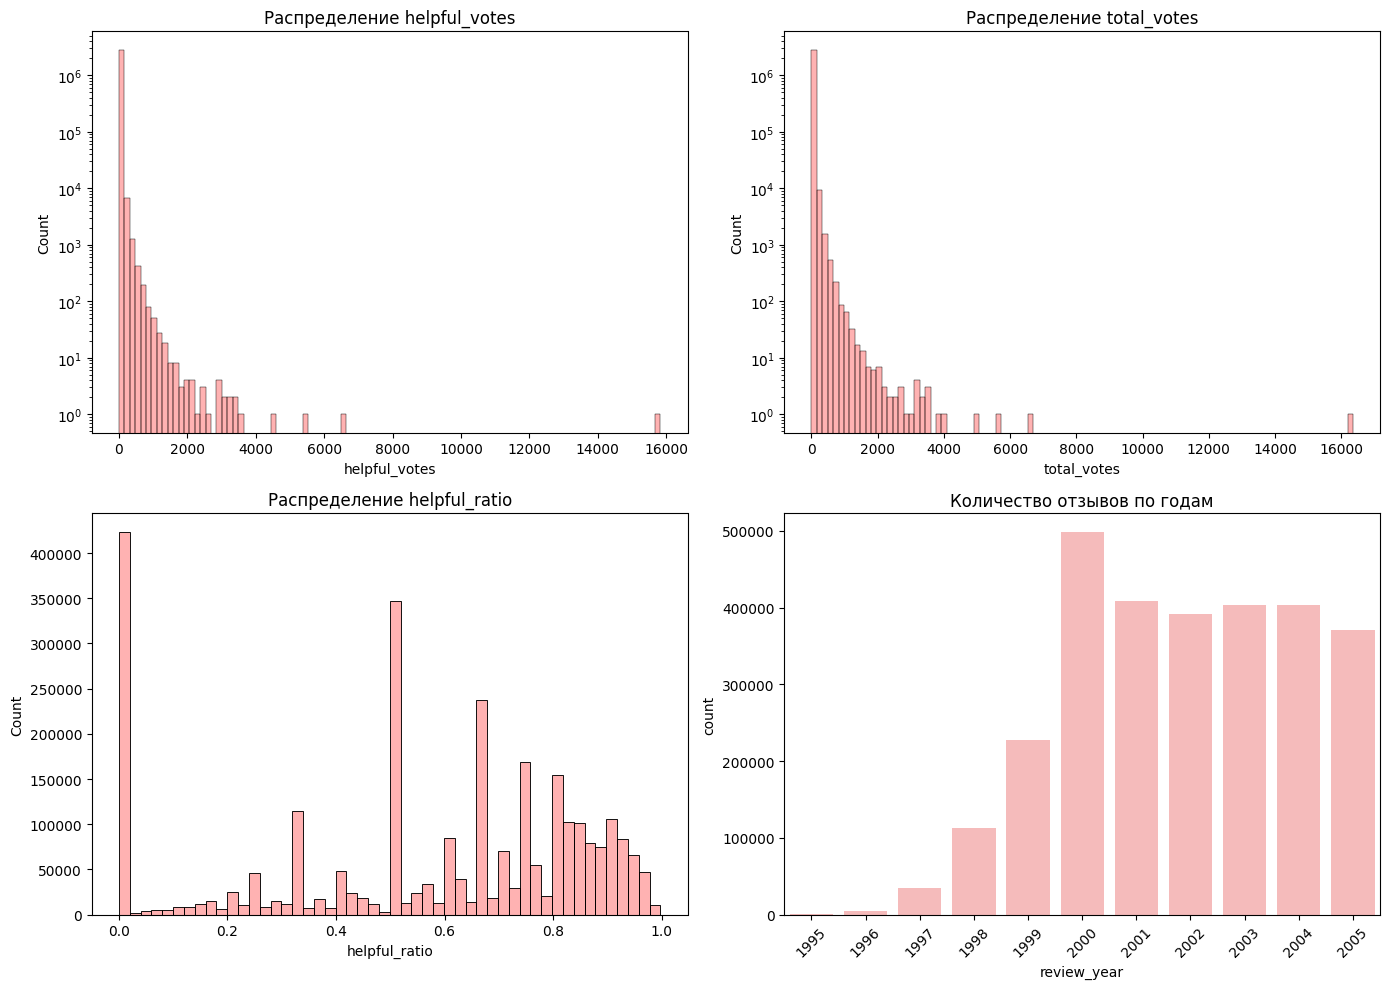

In [17]:
fig, axes = plt.subplots(2, 2, figsize = (14, 10))

# helpful_votes
sns.histplot(data['helpful_votes'], bins = 100, ax = axes[0, 0], log_scale = (False, True), color = 'red', alpha = 0.3)
axes[0, 0].set_title('Распределение helpful_votes')

# total_votes
sns.histplot(data['total_votes'], bins = 100, ax = axes[0, 1], log_scale = (False, True), color = 'red', alpha = 0.3)
axes[0, 1].set_title('Распределение total_votes')

# helpful_ratio
sns.histplot(data['helpful_ratio'], bins = 50, ax = axes[1, 0], color = 'red', alpha = 0.3)
axes[1, 0].set_title('Распределение helpful_ratio')

# review_year
sns.countplot(data = data, x = 'review_year', ax = axes[1, 1], color = 'red', alpha = 0.3)
axes[1, 1].set_title('Количество отзывов по годам')
plt.xticks(rotation = 45)

plt.tight_layout()
plt.show()

> `helpful_votes` и `total_votes` - видим, что большинство отзывов имеют от 0 до 2000 оценок, и есть выбросы до 16к, распределения у них практичекси одинаковые. У обоих длинный хвост, так что модель может быть чувствительна к выбросам, учитывая это лучше использовать их не напрямую, а `прологарифмировать`.<br>

> `helpful_ratio` - много значений под ноликом, вероятно это полное отсутсвие голосов или в целом бесполезные отзывы. Признак сильно разрезжен, но достаточно информативные, ибо признак показывает качество отзыва в глазах других пользователей <br>

> `review_year` - до 99 года отзывов почти нету, можно сказать, что они неинформативны, пик отзывов на 2000 и 2001, а дальше +- стабильно. Можно `агрегировать` в периоды `до 2000`, `2000-2002`, `2003+`

> делаем как говорили выше - логарифмируем `helpful_votes` и `total_votes` после чего избавимся от оригинальных признаков

In [18]:
data['log_helpful_votes'] = np.log1p(data['helpful_votes'])
data['log_total_votes'] = np.log1p(data['total_votes'])

data.drop(columns = ['helpful_votes', 'total_votes'], axis = 1, inplace = True)

data.head()

,vine,verified_purchase,review_headline,review_body,review_date,label,review_year,review_month,helpful_ratio,log_helpful_votes,log_total_votes
0,N,N,this book was a great learning novel!,this boook was a great one that you could lear...,2005-10-14,1,2005,10,0.500000,1.098612,1.386294
2,N,N,this isn't a review,never read it-a young relative idicated he lik...,2005-10-14,1,2005,10,0.043478,0.693147,3.135494
3,N,N,fine author on her A-game,Though she is honored to be Chicago Woman of t...,2005-10-14,1,2005,10,0.666667,1.098612,1.098612
4,N,N,Execellent cursor examination,Review based on a cursory examination by Unive...,2005-10-14,1,2005,10,0.000000,0.000000,1.098612
5,N,N,"Interesting, fun.",My only complaint is that this book was a bit ...,2005-10-14,1,2005,10,0.666667,1.098612,1.098612


> теперь агрегируем даты и избавимся от оригинального признака

In [19]:
def year_bucket(year):
    if year < 2000:
        return 'before_2000'
    elif year <= 2002:
        return '2000_2002'
    else:
        return '2003_and_later'

data['review_year_bucket'] = data['review_year'].apply(year_bucket)

data.drop(['review_year', 'review_date'], axis = 1, inplace = True)

data.head()

,vine,verified_purchase,review_headline,review_body,label,review_month,helpful_ratio,log_helpful_votes,log_total_votes,review_year_bucket
0,N,N,this book was a great learning novel!,this boook was a great one that you could lear...,1,10,0.500000,1.098612,1.386294,2003_and_later
2,N,N,this isn't a review,never read it-a young relative idicated he lik...,1,10,0.043478,0.693147,3.135494,2003_and_later
3,N,N,fine author on her A-game,Though she is honored to be Chicago Woman of t...,1,10,0.666667,1.098612,1.098612,2003_and_later
4,N,N,Execellent cursor examination,Review based on a cursory examination by Unive...,1,10,0.000000,0.000000,1.098612,2003_and_later
5,N,N,"Interesting, fun.",My only complaint is that this book was a bit ...,1,10,0.666667,1.098612,1.098612,2003_and_later


---

# Анализ влияния категориальных (бинарных) признаков на целевой

> у нас два бинарных признака `verified_purchase` - проверенная прокупка и `vine` - отзыв в рамках некой программы vine

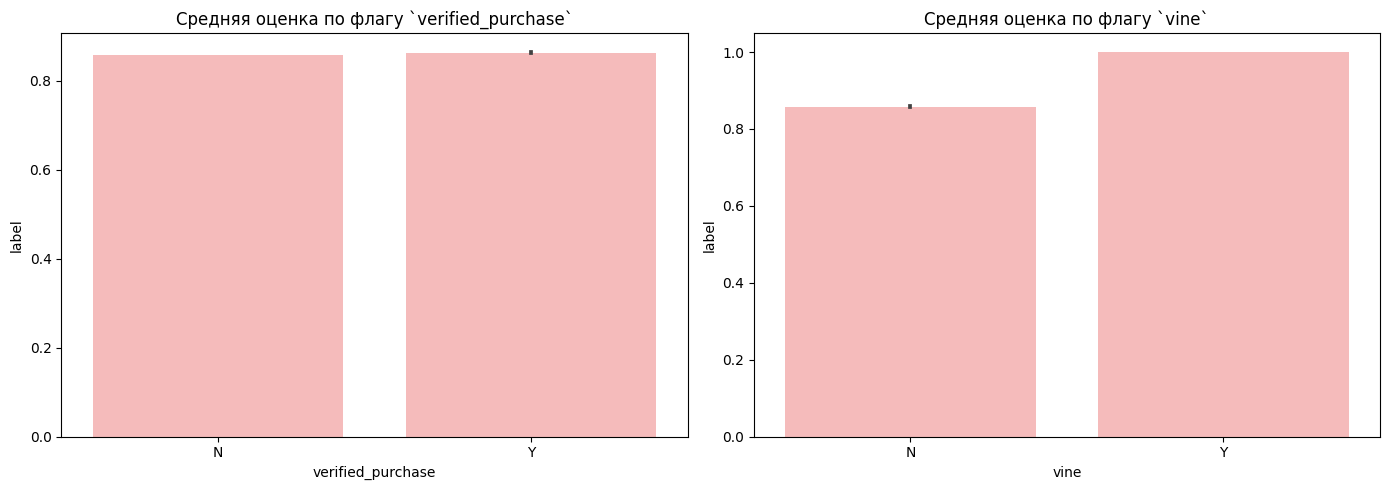

In [20]:
fig, axes = plt.subplots(1, 2, figsize = (14, 5))

# verified_purchase
sns.barplot(data = data, x = 'verified_purchase', y = 'label', ax = axes[0], color = 'red', alpha = 0.3)
axes[0].set_title('Средняя оценка по флагу `verified_purchase`')

# vine
sns.barplot(data = data, x = 'vine', y = 'label', ax = axes[1], color = 'red', alpha = 0.3)
axes[1].set_title('Средняя оценка по флагу `vine`')

plt.tight_layout()
plt.show()

> `verified_purchase` - отличия минимальны, можно сказать, что сам факт покупки не сильно влияет на оценку
>
> `vine` - оценки программы vine немного дают более высокие оценки, но не сказать, что прирост сильно заметен относительно другого признака

> Посмотим на распредление флагов - как много участников программы vine и как много отзывов с подтвержденной покупкой

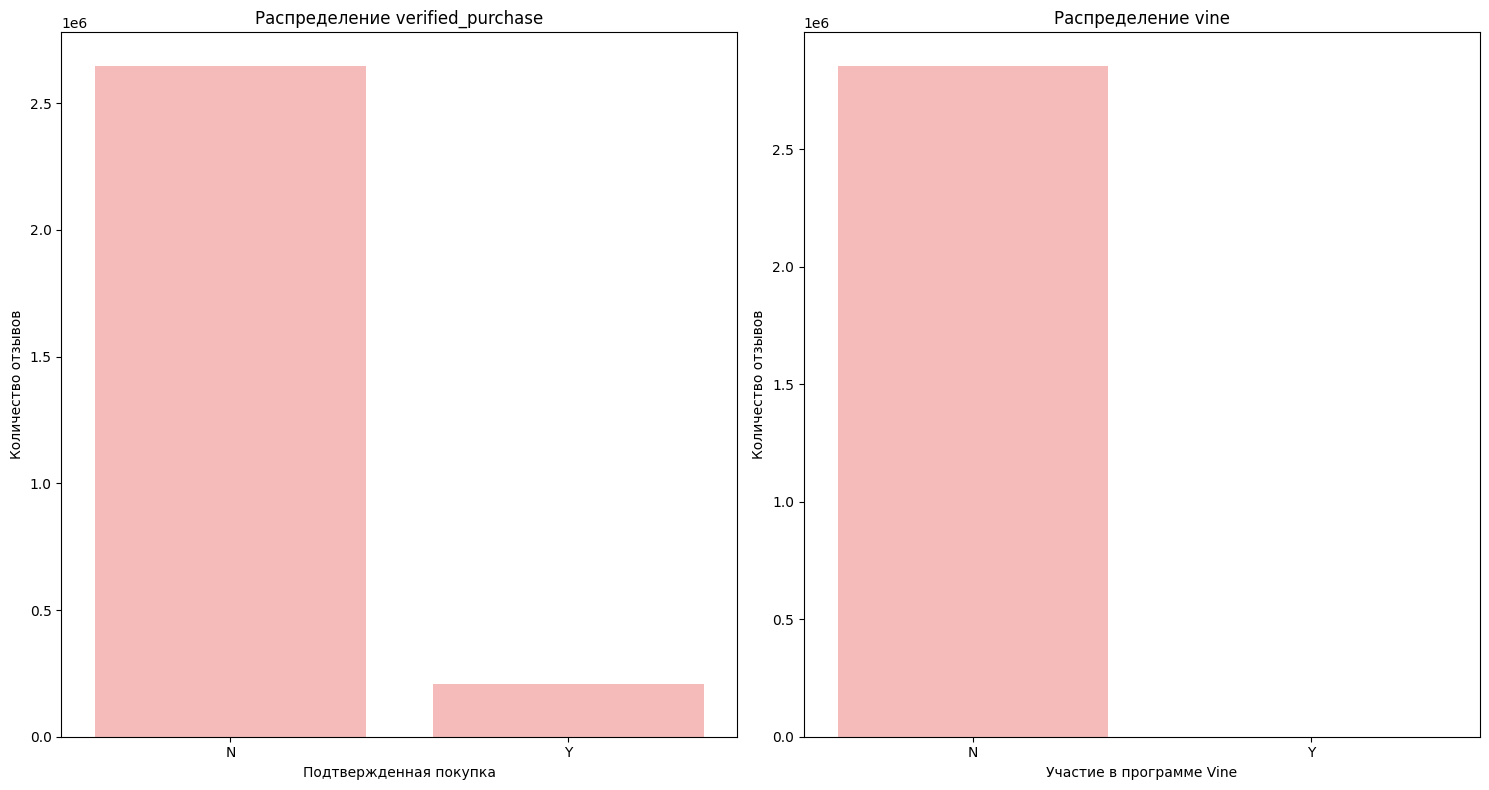

In [21]:
fig, axes = plt.subplots(1, 2, figsize = (15, 8))

# verified_purchase
sns.countplot(data = data, x = 'verified_purchase', ax = axes[0], color = 'red', alpha = 0.3)
axes[0].set_title('Распределение verified_purchase')
axes[0].set_xlabel('Подтвержденная покупка')
axes[0].set_ylabel('Количество отзывов')

# vine
sns.countplot(data = data, x = 'vine', ax = axes[1], color = 'red', alpha = 0.3)
axes[1].set_title('Распределение vine')
axes[1].set_xlabel('Участие в программе Vine')
axes[1].set_ylabel('Количество отзывов')

plt.tight_layout()
plt.show()

> `verified_purchase` - мы выяснили, что подтвержденная покупка имеет среднюю оценку как и не подтвержденная покупка, признак не влияет на оценку так что можно избавляться
>
> `vine` - участников программы vine практически нет, можно удалить, чтобы не создавать лишний шум

In [22]:
data.drop(['verified_purchase', 'vine'], axis = 1, inplace = True)

data.head()

,review_headline,review_body,label,review_month,helpful_ratio,log_helpful_votes,log_total_votes,review_year_bucket
0,this book was a great learning novel!,this boook was a great one that you could lear...,1,10,0.500000,1.098612,1.386294,2003_and_later
2,this isn't a review,never read it-a young relative idicated he lik...,1,10,0.043478,0.693147,3.135494,2003_and_later
3,fine author on her A-game,Though she is honored to be Chicago Woman of t...,1,10,0.666667,1.098612,1.098612,2003_and_later
4,Execellent cursor examination,Review based on a cursory examination by Unive...,1,10,0.000000,0.000000,1.098612,2003_and_later
5,"Interesting, fun.",My only complaint is that this book was a bit ...,1,10,0.666667,1.098612,1.098612,2003_and_later


----

# Анализ признаков с текстом

> nекстовые признаки `review_body`, `review_headline` - важные признаки из которых можно извлечь важную информацию <br><br>
> посмотрим на распредление длинны текстов и заголовков

In [23]:
data['review_length'] = data['review_body'].apply(len)
data['headline_length'] = data['review_headline'].apply(len)

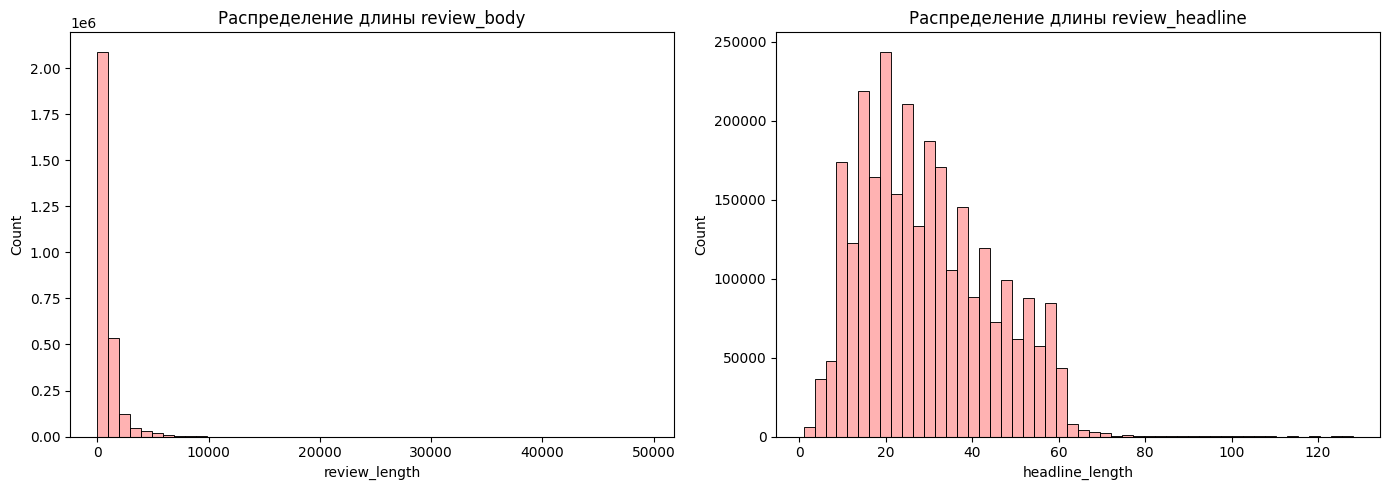

In [24]:
fig, axes = plt.subplots(1, 2, figsize = (14, 5))

# review_length
sns.histplot(data['review_length'], bins = 50, ax = axes[0], color = 'red', alpha = 0.3)
axes[0].set_title('Распределение длины review_body')

# headline_length
sns.histplot(data['headline_length'], bins = 50, ax = axes[1], color = 'red', alpha = 0.3)
axes[1].set_title('Распределение длины review_headline')

plt.tight_layout()
plt.show()

> `review_body` - очень много отзывов короткие и укладываются в диапазон длины до 10000 символов, так как шкала x размазалась до 50000 значит есть и отзывы с таким количеством символов, но их очень мало, так как их даже не видно <br>

> `headline_length` - есть строки с очень маленьким кол-вом символов, но есть и хвост с большим количеством

> соединим признаки, чтобы не плодить лишнего 

In [25]:
data['review_text'] = data['review_headline'] + ' ' + data['review_body']

data.drop(['review_headline', 'review_body'], axis = 1, inplace = True)

In [26]:
# кол-во токенов review_body
data['review_len_words'] = data['review_text'].apply(lambda x: len(str(x).split()))

# кол-во восклицательных знаков
data['exclamation_count'] = data['review_text'].str.count('!')

> почистим текст от пунктуации, чисел, приведем к нижнему регистру и удалим стоп слова

In [27]:
def preprocess_text(text):
    if pd.isna(text):
        return ""
    text = text.lower() # нижний регистр
    text = re.sub(r'\d+', '', text)  # удаление цифр
    text = text.translate(str.maketrans('', '', string.punctuation))  # удаление пунктуации

    tokens = text.split() # делим на токены
    tokens = [word for word in tokens if word not in ENGLISH_STOP_WORDS]

    return ' '.join(tokens)

data['review_clean'] = data['review_text'].apply(preprocess_text)

data.drop(['review_text'], axis = 1, inplace = True)

> установим флаг на пустые и короткие отзывы для последующей обработки

In [28]:
# кол-во токенов после очистки
data['review_len_words_clean'] = data['review_clean'].apply(lambda x: len(x.split()))

# поставим флаг, на короткие и пустые отзывы
data['short_review_flag'] = data['review_len_words'] < 3
data['empty_review_flag'] = data['review_len_words'] == 0

data.head()

,label,review_month,helpful_ratio,log_helpful_votes,log_total_votes,review_year_bucket,review_length,headline_length,review_len_words,exclamation_count,review_clean,review_len_words_clean,short_review_flag,empty_review_flag
0,1,10,0.500000,1.098612,1.386294,2003_and_later,1320,37,251,1,book great learning novel boook great learn te...,98,False,False
2,1,10,0.043478,0.693147,3.135494,2003_and_later,104,19,23,0,isnt review read ita young relative idicated l...,11,False,False
3,1,10,0.666667,1.098612,1.098612,2003_and_later,1588,25,271,0,fine author agame honored chicago woman year v...,145,False,False
4,1,10,0.000000,0.000000,1.098612,2003_and_later,508,29,93,0,execellent cursor examination review based cur...,45,False,False
5,1,10,0.666667,1.098612,1.098612,2003_and_later,1026,17,193,0,interesting fun complaint book bit repetative ...,83,False,False


> удалим короткие и пустые отзывы

In [29]:
print(data['short_review_flag'].value_counts())
print(data['empty_review_flag'].value_counts())

short_review_flag
False    2855208
True          78
Name: count, dtype: int64
empty_review_flag
False    2855286
Name: count, dtype: int64


> от признака `empty_review_flag` избавляемся, видим, что нет отзывов с 0 символами
>
>а благодаря признаку `short_review_flag` удалим отзывы у которых меньше 3 слов, потом он тоже будет бесполезный и мы избавимся от него

In [30]:
data = data[~data['short_review_flag']]

print(data['short_review_flag'].value_counts())

short_review_flag
False    2855208
Name: count, dtype: int64


In [31]:
data.drop(['empty_review_flag', 'short_review_flag'], axis = 1, inplace = True)

data.head()

,label,review_month,helpful_ratio,log_helpful_votes,log_total_votes,review_year_bucket,review_length,headline_length,review_len_words,exclamation_count,review_clean,review_len_words_clean
0,1,10,0.500000,1.098612,1.386294,2003_and_later,1320,37,251,1,book great learning novel boook great learn te...,98
2,1,10,0.043478,0.693147,3.135494,2003_and_later,104,19,23,0,isnt review read ita young relative idicated l...,11
3,1,10,0.666667,1.098612,1.098612,2003_and_later,1588,25,271,0,fine author agame honored chicago woman year v...,145
4,1,10,0.000000,0.000000,1.098612,2003_and_later,508,29,93,0,execellent cursor examination review based cur...,45
5,1,10,0.666667,1.098612,1.098612,2003_and_later,1026,17,193,0,interesting fun complaint book bit repetative ...,83


> посмотрим на основные значения наших новых характеристик текстовых признаков

In [32]:
print(data[['review_length', 'review_len_words', 'review_len_words_clean']].describe())

       review_length  review_len_words  review_len_words_clean
count   2.855208e+06      2.855208e+06            2.855208e+06
mean    8.748684e+02      1.552451e+02            7.291018e+01
std     9.537103e+02      1.590180e+02            7.629527e+01
min     1.000000e+00      3.000000e+00            1.000000e+00
25%     3.450000e+02      6.600000e+01            3.000000e+01
50%     5.890000e+02      1.080000e+02            5.000000e+01
75%     1.038000e+03      1.850000e+02            8.600000e+01
max     4.935800e+04      1.073900e+04            4.002000e+03


> видим следующее
>- медиана 50%: примерно 100 слов и 600 символов — средняя длина типичного отзыва
>- по разбросу: есть очень длинные отзывы, так что их лучше прологарифмировать
>- review_len_words_clean после предобработки кол-во слов становистя заметно меньше, можем сделать вывод, что очистка справилась хорошо и мы избавились от шумов

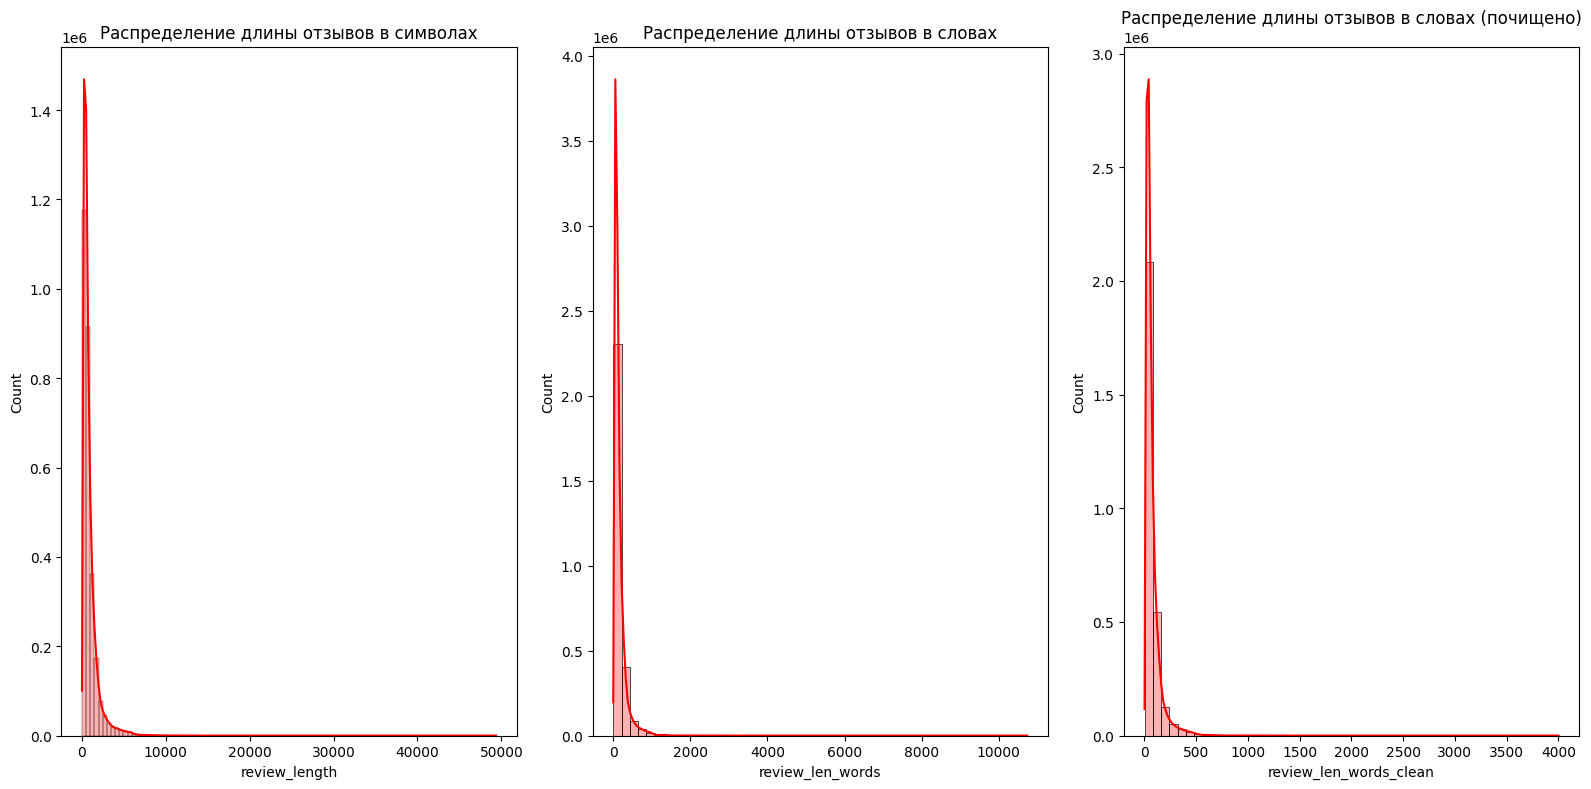

In [33]:
fig, axes = plt.subplots(1, 3, figsize = (16, 8))

# review_len_chars
sns.histplot(data['review_length'], bins = 100, kde = True, ax = axes[0], color = 'red', alpha = 0.3)
axes[0].set_title("Распределение длины отзывов в символах")

# review_len_words
sns.histplot(data['review_len_words'], bins = 50, kde = True, ax = axes[1], color = 'red', alpha = 0.3)
axes[1].set_title("Распределение длины отзывов в словах")

# review_len_words_clean
sns.histplot(data['review_len_words_clean'], bins = 50, kde = True, ax = axes[2], color = 'red', alpha = 0.3)
axes[2].set_title("Распределение длины отзывов в словах (почищено)")

plt.tight_layout()
plt.show()

> теперь наглядно можно разобрать, что разброс достаточно сильный - длинный правый хвост. Чтобы сжать это безобразие прологарифмируем

In [34]:
data['log_review_len_chars'] = np.log1p(data['review_length'])
data['log_review_len_words'] = np.log1p(data['review_len_words'])
data['log_review_len_clean_tokens'] = np.log1p(data['review_len_words_clean'])

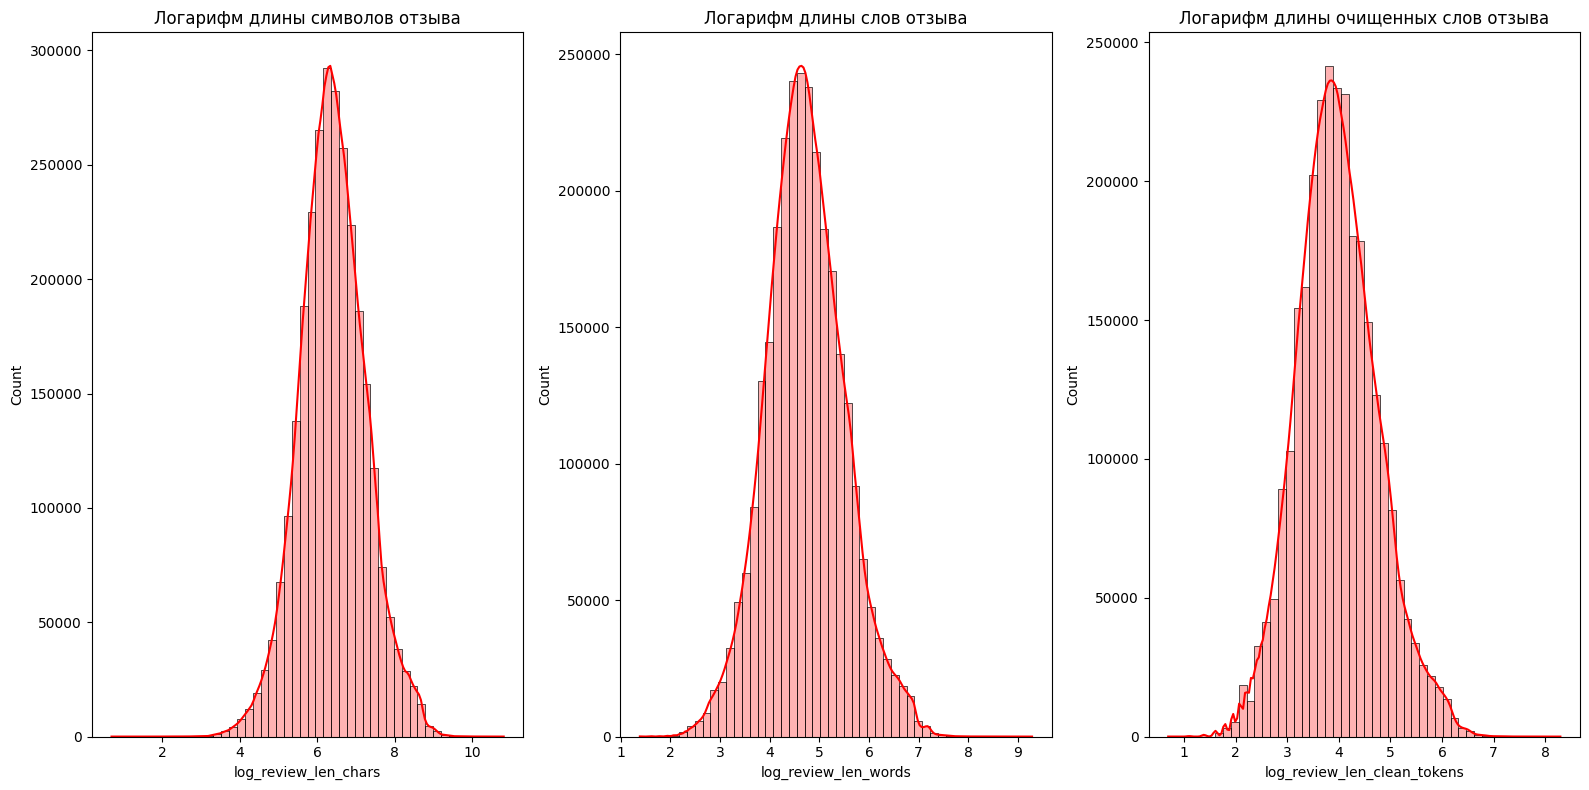

In [35]:
fig, axes = plt.subplots(1, 3, figsize = (16, 8))

sns.histplot(data['log_review_len_chars'], bins = 50, kde = True, ax = axes[0], color = 'red', alpha = 0.3)
axes[0].set_title('Логарифм длины символов отзыва')

sns.histplot(data['log_review_len_words'], bins = 50, kde = True, ax = axes[1], color = 'red', alpha = 0.3)
axes[1].set_title('Логарифм длины слов отзыва')

sns.histplot(data['log_review_len_clean_tokens'], bins = 50, kde = True, ax = axes[2], color = 'red', alpha = 0.3)
axes[2].set_title('Логарифм длины очищенных слов отзыва')

plt.tight_layout()
plt.show()

> после логарифмирования, распределение выгляит как нормальное

> теперь разберемся, нужно ли удалять изначальные признаки

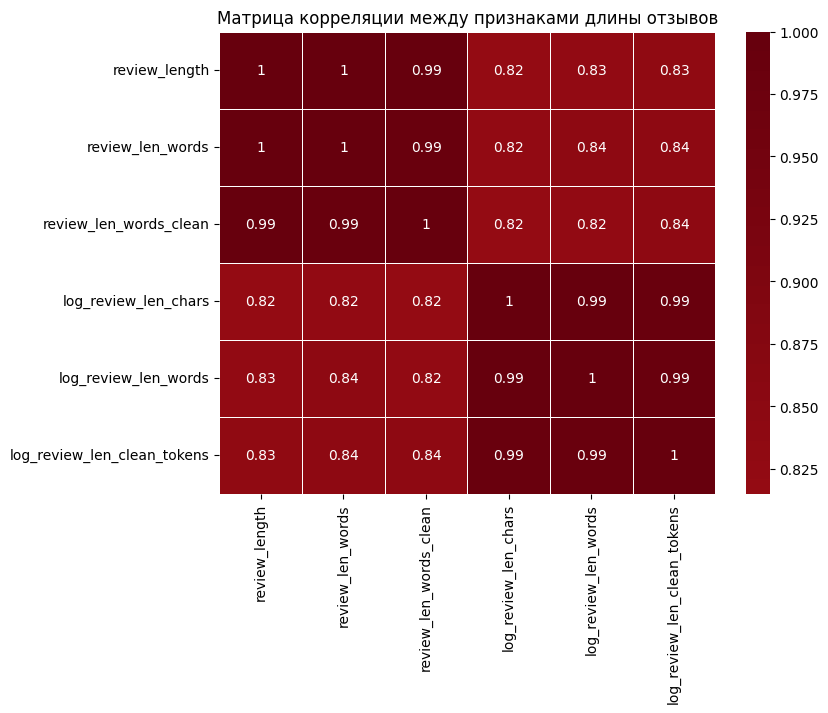

In [36]:
corr_matrix = data[['review_length', 'review_len_words', 'review_len_words_clean',
                  'log_review_len_chars', 'log_review_len_words', 'log_review_len_clean_tokens']].corr()

plt.figure(figsize = (8, 6))
sns.heatmap(corr_matrix, annot = True, center = 0, linewidths = 0.5, cmap="Reds")

plt.title("Матрица корреляции между признаками длины отзывов")
plt.show()

> корреляция очеь сильная, поэтому убираем, ну и сами хвосты создающие шум тоже как фактор

In [37]:
data.drop(['review_length', 'review_len_words', 'review_len_words_clean'], axis = 1, inplace = True)

data.head()

,label,review_month,helpful_ratio,log_helpful_votes,log_total_votes,review_year_bucket,headline_length,exclamation_count,review_clean,log_review_len_chars,log_review_len_words,log_review_len_clean_tokens
0,1,10,0.500000,1.098612,1.386294,2003_and_later,37,1,book great learning novel boook great learn te...,7.186144,5.529429,4.595120
2,1,10,0.043478,0.693147,3.135494,2003_and_later,19,0,isnt review read ita young relative idicated l...,4.653960,3.178054,2.484907
3,1,10,0.666667,1.098612,1.098612,2003_and_later,25,0,fine author agame honored chicago woman year v...,7.370860,5.605802,4.983607
4,1,10,0.000000,0.000000,1.098612,2003_and_later,29,0,execellent cursor examination review based cur...,6.232448,4.543295,3.828641
5,1,10,0.666667,1.098612,1.098612,2003_and_later,17,0,interesting fun complaint book bit repetative ...,6.934397,5.267858,4.430817


---

# TF IDF

>Для начала, нужно понять какой минимум и максмум будем брать для исключения
> - минимум - убирает редкие слова, например если поставим 5 - то слово должно встретиться хотябы в 5 отзывах
> - максимум - убирает частые, например 0.8 - слово, которое есть в 80 и более процентах отзызвов
>
>чтобы определеить это дело надо посмотреть на распредлеение частот слов

In [38]:
cv = CountVectorizer()
X_counts = cv.fit_transform(data['review_clean'])

word_freq = np.asarray(X_counts.sum(axis = 0)).flatten()
vocab = np.array(cv.get_feature_names_out())

freq_df = pd.DataFrame({'word': vocab,
                        'freq': word_freq})

freq_df.sort_values('freq', ascending=False).head(20)

,word,freq
240983,book,6034724
260425,br,1959234
1831604,read,1957704
1197304,like,1044733
873107,great,975278
2112136,story,951364
859089,good,922826
1106424,just,885343
247132,books,883514
2236338,time,787531


In [39]:
import gc
gc.collect()

59184

> посмторим наглядно на распределения частот слов, чтобы увидеть как быстро и часто падает частота

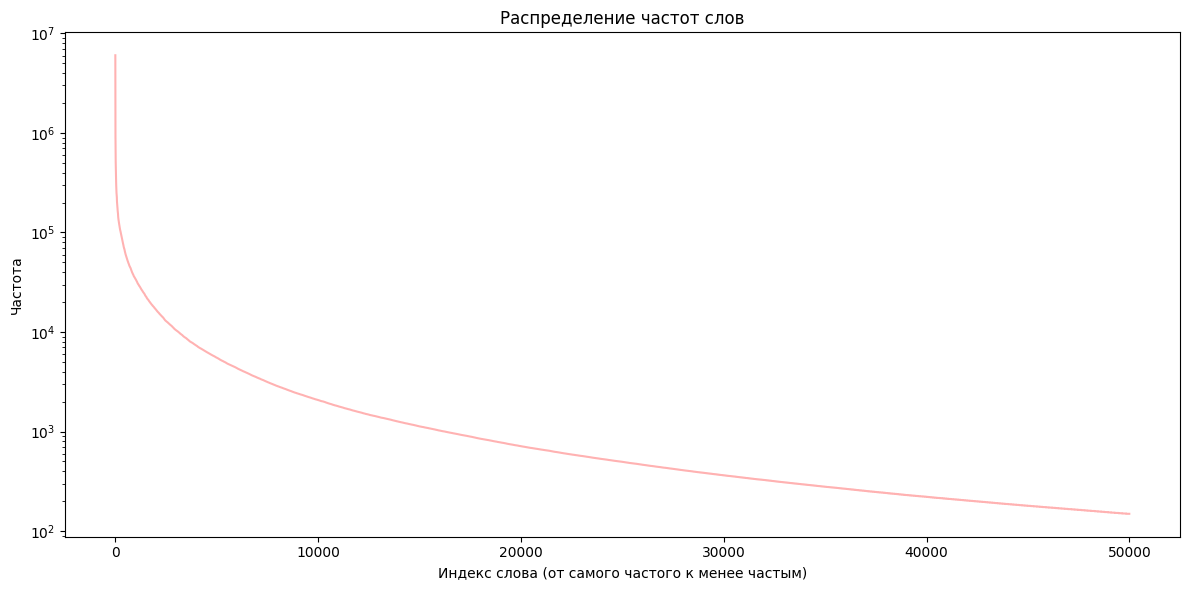

In [40]:
# Сортируем по убыванию частот
sorted_freqs = np.sort(word_freq)[::-1]

plt.figure(figsize=(12, 6))

plt.plot(sorted_freqs[:50000], color = 'red', alpha = 0.3)
plt.yscale('log')

plt.title('Распределение частот слов')
plt.xlabel('Индекс слова (от самого частого к менее частым)')
plt.ylabel('Частота')

plt.tight_layout()
plt.show()

>Гистограмма для частот, чтобы оценить min_df

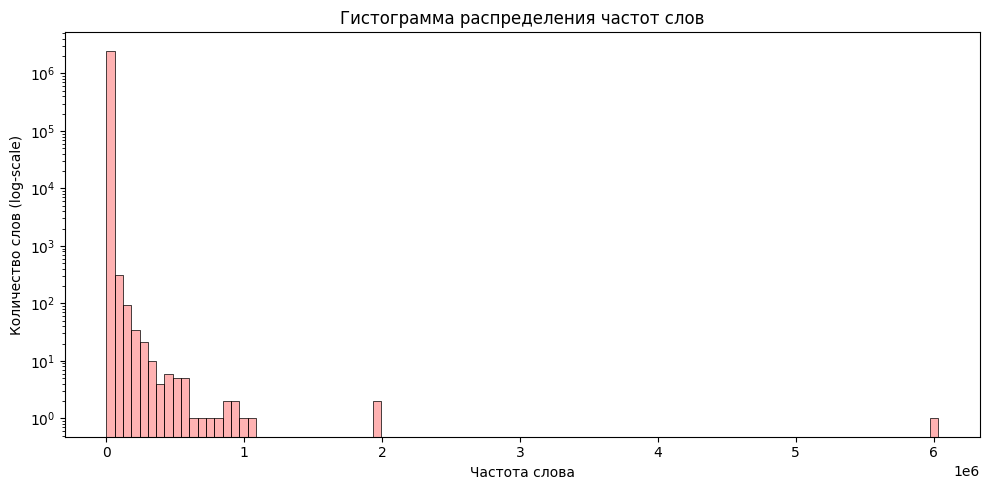

In [41]:
plt.figure(figsize = (10, 5))

sns.histplot(word_freq, bins = 100, log = True, color = 'red', alpha = 0.3)

plt.title("Гистограмма распределения частот слов")
plt.xlabel("Частота слова")
plt.ylabel("Количество слов (log-scale)")

plt.tight_layout()
plt.show()

>переводим числа в долю, для max_df

In [42]:
# оценка - сколько слов встречается более чем в 80% отзывов
total_docs = X_counts.shape[0]
doc_freq = (X_counts > 0).sum(axis = 0).A1  # сколько отзывов содержит каждое слово
share = doc_freq / total_docs

print(f"Слов встречается в >80% отзывов: {(share > 0.8).sum()}")
print(f"Слов встречается менее чем в 5 отзывах: {(doc_freq < 5).sum()}")

Слов встречается в >80% отзывов: 0
Слов встречается менее чем в 5 отзывах: 2122023


> - видим, что у нас нет слов, которые встречаются слишком часто в >80% отзывах, поэтому max_df не удалит ничего<br>
> - так же заметим, что у нас очень много редких слов, которые встречаются менее чем в 5 отзывах - это вероятнее всего шум<br>

> получаем следующее:<br>
>- max_df - можно не задавать
>- min_df = 5 - избавимся от хвоста бесполезных слов

> перейдем к tf-idf и ngrams

> мы определили max_df и min_df<br>
> сначала посмотрим на униграммы, потом добавим лемматизацию

In [43]:
tfidf_uni = TfidfVectorizer(
    min_df = 5,         # убираем редкие
    ngram_range = (1, 1),  # только униграммы
    max_features = None,     # словарь не ограничиваем
)

X_tfidf_uni = tfidf_uni.fit_transform(data['review_clean'])

print(f"размер матрицы TF-IDF (униграммы): {X_tfidf_uni.shape}")

размер матрицы TF-IDF (униграммы): (2855208, 364403)


> 2 855 208 — количество документов (отзывов)<br>
> 364 403 — количество признаков (уникальных слов после фильтрации по min_df=5)

> перейдем к лемматизации, приведем слова к начаальным формам так же удалим слова которые встречаются менее чем в 5 отзывах и посмотрим как это полияет на данные

In [44]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


True

> определим лемматизатор, так как мы уже почистили текст ранее применим только лемматизацию и применим это дело в tfidf

In [45]:
lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    tokens = text.split()
    lemmas = [lemmatizer.lemmatize(token) for token in tokens]
    return lemmas
    

tfidf_lem = TfidfVectorizer(
    tokenizer = lemmatize_text,  # применим лемматизацию
    min_df = 5,
    ngram_range = (1, 1),
    max_features = None
)

X_tfidf_lem = tfidf_lem.fit_transform(data['review_clean'])

print(f"Размер матрицы TF-IDF после лемматизации: {X_tfidf_lem.shape}")

Размер матрицы TF-IDF после лемматизации: (2855208, 344724)


> 2 855 008 — количество документов (отзывов)<br>
> 344 724 — количество признаков (уникальных слов после фильтрации по min_df=5 и лемматизации)
>
> посмотрим как лемматизация повлияла на данные

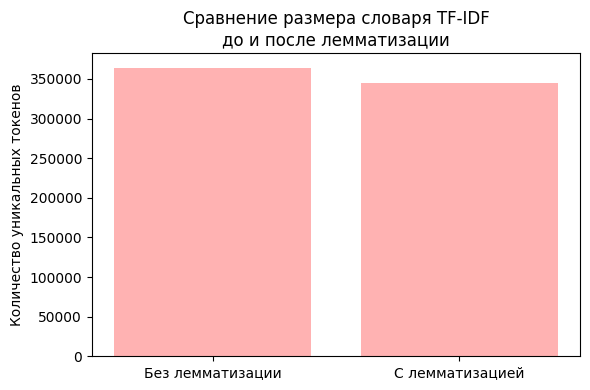

In [46]:
# размеры словарей
vocab_size_uni = len(tfidf_uni.get_feature_names_out())
vocab_size_lem = len(tfidf_lem.get_feature_names_out())

plt.figure(figsize=(6, 4))

plt.bar(['Без лемматизации', 'С лемматизацией'], [vocab_size_uni, vocab_size_lem], color = 'red', alpha = 0.3)

plt.title('Сравнение размера словаря TF-IDF\nдо и после лемматизации')
plt.ylabel('Количество уникальных токенов')

plt.tight_layout()
plt.show()

> в целом не сильно поменялось, но все же лучше чем ничего

In [47]:
del X_tfidf_uni
gc.collect()

2599

---

# Анализ и подготовка признаков для SVM

>SVM сам по себе чувствительный к масштабу, поэтому все наши числовые признаки нужно стандартизировать, но перед этим посмотрим на корреляцию всех числовых признаков с целевым, чтобы выкинуть те, что очевидно будут портить результат

In [48]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2855208 entries, 0 to 3105369
Data columns (total 12 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   label                        int64  
 1   review_month                 int32  
 2   helpful_ratio                float64
 3   log_helpful_votes            float64
 4   log_total_votes              float64
 5   review_year_bucket           object 
 6   headline_length              int64  
 7   exclamation_count            int64  
 8   review_clean                 object 
 9   log_review_len_chars         float64
 10  log_review_len_words         float64
 11  log_review_len_clean_tokens  float64
dtypes: float64(6), int32(1), int64(3), object(2)
memory usage: 272.3+ MB


> у нас есть признак review_year_bucket который мы сделали из признака "год", который вытащили из даты, закодируем его через one hot encoding           

In [49]:
year_dummies = pd.get_dummies(data['review_year_bucket'], prefix='year')

bool_columns = ['year_2000_2002', 'year_2003_and_later', 'year_before_2000']
data = pd.concat([data.drop('review_year_bucket', axis=1), year_dummies], axis=1)

data[bool_columns] = data[bool_columns].astype('int8')

data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2855208 entries, 0 to 3105369
Data columns (total 14 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   label                        int64  
 1   review_month                 int32  
 2   helpful_ratio                float64
 3   log_helpful_votes            float64
 4   log_total_votes              float64
 5   headline_length              int64  
 6   exclamation_count            int64  
 7   review_clean                 object 
 8   log_review_len_chars         float64
 9   log_review_len_words         float64
 10  log_review_len_clean_tokens  float64
 11  year_2000_2002               int8   
 12  year_2003_and_later          int8   
 13  year_before_2000             int8   
dtypes: float64(6), int32(1), int64(3), int8(3), object(1)
memory usage: 258.7+ MB


> посмотрим на корреляцию 

In [50]:
corrs = data.select_dtypes(include=[np.number]).corr()['label'].sort_values(key=abs, ascending=False)
print(corrs)

label                          1.000000
log_total_votes               -0.234368
log_helpful_votes             -0.110105
helpful_ratio                  0.109306
headline_length                0.059562
exclamation_count              0.039353
year_2003_and_later           -0.033187
year_2000_2002                 0.023206
year_before_2000               0.014096
log_review_len_chars          -0.012879
log_review_len_words          -0.012528
log_review_len_clean_tokens   -0.002485
review_month                   0.001222
Name: label, dtype: float64


>`label`                          1.000000 - целевая <br>
>`log_total_votes`               -0.234368 - умеренно отрицательно коррелируют, скорее всего, отражают негативные оценки <br>
>`log_helpful_votes`             -0.110105 - умеренно отрицательно коррелируют, скорее всего, отражают негативные оценки <br>
>`helpful_ratio`                  0.109306 - положительная корреляция (небольшая, но есть) <br>
>`headline_length`                0.059562 - положительная корреляция (небольшая, но есть) <br>
>`exclamation_count`              0.039353 - Восклицательные знаки чуть чаще в позитивных <br>
>`year_2003_and_later`           -0.033187 <br>
>`year_2000_2002`                 0.023206 <br>
>`year_before_2000`               0.014096 <br>
>`log_review_len_chars`          -0.012879 <br>
>`log_review_len_words`          -0.012528 <br>
>`log_review_len_clean_tokens`   -0.002485 <br>
>`review_month`                   0.001222 <br>

> в итоге избавимся от review_month log_review_len_clean_tokens, самые бесполезные. 

In [51]:
data.drop(['review_month', 'log_review_len_clean_tokens'], axis = 1, inplace = True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2855208 entries, 0 to 3105369
Data columns (total 12 columns):
 #   Column                Dtype  
---  ------                -----  
 0   label                 int64  
 1   helpful_ratio         float64
 2   log_helpful_votes     float64
 3   log_total_votes       float64
 4   headline_length       int64  
 5   exclamation_count     int64  
 6   review_clean          object 
 7   log_review_len_chars  float64
 8   log_review_len_words  float64
 9   year_2000_2002        int8   
 10  year_2003_and_later   int8   
 11  year_before_2000      int8   
dtypes: float64(5), int64(3), int8(3), object(1)
memory usage: 226.0+ MB


> теперь, когда мы уверены в признаках, нормализуем их с помощью StandardScaler

In [52]:
num_features = ['helpful_ratio', 'log_helpful_votes', 'log_total_votes', \
                'headline_length', 'exclamation_count', 'log_review_len_chars', \
                'log_review_len_words', 'year_2000_2002', 'year_2003_and_later', 'year_before_2000']

scaler = StandardScaler()
X_num = scaler.fit_transform(data[num_features])

X_num[1]

array([-1.67948854, -0.85418878,  1.09513876, -0.72048398, -0.38279695,
       -2.04436625, -1.95506655, -0.91266152,  1.19283894, -0.39138398])

> теперь объединим TF IDF и числовые признаки и обозначим целевой признак

In [53]:
X_full = hstack([X_tfidf_lem, X_num])

# целевой признак
y = data['label'] 

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X_full, y, test_size = 0.2, random_state = 7, stratify = y)
# stratify = y — гарантирует, что доли классов в train/test совпадают

print(f'X_train: {X_train.shape}')
print(f'X_test: {X_test.shape}')
print(f'y_train: {y_train.shape}')
print(f'y_test: {y_test.shape}')

X_train: (2284166, 344734)
X_test: (571042, 344734)
y_train: (2284166,)
y_test: (571042,)


In [55]:
del X_tfidf_lem
del X_num
del X_full
del y
del data

---

# SVM

> Наконец перейдем к созданию и обучению модели
>
> Используем LinearSVC так как оно больше подходит для больших данных - будет быстрее обучаться, будут более устойчивы к шуму благодаря L2 регуляризации и лучше работает с разреженными матрицами - у нас был применен tf-idf из-за которого и создается много нулевых значений

In [56]:
svm = LinearSVC(class_weight='balanced', random_state=7)
svm.fit(X_train, y_train)

LinearSVC(class_weight='balanced', random_state=7)

---

# Результаты

> Предсказание и метрики

In [57]:
y_pred = svm.predict(X_test)

print(f"Точность: {accuracy_score(y_test, y_pred)}")

print(classification_report(y_test, y_pred))

Точность: 0.9310173332259274
              precision    recall  f1-score   support

           0       0.70      0.89      0.79     80909
           1       0.98      0.94      0.96    490133

    accuracy                           0.93    571042
   macro avg       0.84      0.92      0.87    571042
weighted avg       0.94      0.93      0.93    571042



> класс 0 (негативные отзывы)
> - precision = 0.70 - 30% предсказаний негативов - это ошибки (ложноположительные)
> - recall = 0.89 - модель находит почти все настоящие негативные отзывы
> - f1 = 0.79 - сбалансированная метрика между precision и recall - средняя, модель путается в негативных

> класс 1 (позитивные отзывы)
> - precision = 0.98 - почти все предсказанные позитивные отзывы — действительно позитивные
> - recall = 0.94 - 6% позитивных отзывов модель пропускает
> - f1 = 0.96 - отличное качество на положительном классе

> матрица ошибок

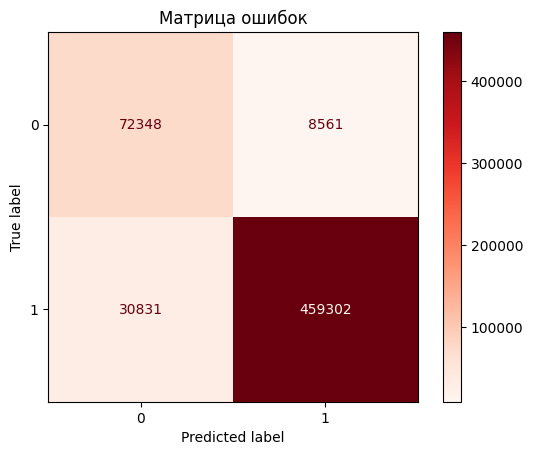

In [58]:
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = svm.classes_)
disp.plot(cmap='Reds')

plt.title('Матрица ошибок')

plt.show()

> `True Positives` - 459 302 - правильные положительные отзывы<br>
> `True Negatives` - 72,348 - правильные отрицательные<br>
> `False Positives` - 8,561 - ошибочно посчитала отрицательные за положительные<br>
> `False Negatives` - 30,831 - не узнала положительные, посчитала их отрицательными<br>